In [16]:
import os
import random
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from torch_geometric.utils import add_self_loops, from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy import sparse
import anndata as ad
from torch.distributions import NegativeBinomial, Normal, kl_divergence as kl
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [2]:

def validate_reconstruction(adata_full: sc.AnnData, reconstructed_atac_np: np.ndarray, gene_to_plot: str):

    adata_orig = adata_full.copy()
    
    if isinstance(adata_orig.X, sparse.spmatrix):
        adata_orig.X = adata_orig.X.toarray()
        
    # Create AnnData object for reconstructed data
    adata_recon = sc.AnnData(
        reconstructed_atac_np, 
        obs=adata_orig.obs.copy(), 
        var=adata_orig.var.copy()
    )
    adata_recon.obsm['spatial'] = adata_orig.obsm['spatial'].copy()

    print(f"\nVisualizing spatial accessibility patterns for Peak: '{gene_to_plot}'...")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Plot original accessibility
    sc.pl.embedding(adata_orig, basis="spatial", color=[gene_to_plot], title=f"Original - {gene_to_plot}", 
                    show=False, ax=axes[0], cmap='viridis')
    
    # Plot reconstructed accessibility
    sc.pl.embedding(adata_recon, basis="spatial", color=[gene_to_plot], title=f"Reconstructed - {gene_to_plot}", 
                    show=False, ax=axes[1], cmap='viridis')
    
    plt.tight_layout()
    plt.show()

    # Quantitative analysis
    orig_expr = adata_orig[:, gene_to_plot].X.flatten()
    recon_expr = adata_recon[:, gene_to_plot].X.flatten()
    
    # Calculate Pearson Correlation
    corr, p_value = pearsonr(orig_expr, recon_expr)
    print(f"\n--- Quantitative Analysis ('{gene_to_plot}') ---")
    print(f"Pearson Correlation (Original vs Reconstructed): {corr:.4f} (P-value: {p_value:.4e})\n")

In [3]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
from pathlib import Path
from scipy.io import mmwrite

In [4]:
def prepare_rna_data(data_dir: str,
                     use_bce_loss: bool = False,
                     n_neighbors: int = 3):

    print("--- Loading and preprocessing data ---")

    # Load AnnData objects for both samples
    S1_RNA_data = sc.read_h5ad(os.path.join(data_dir, 'To_train_E15_5-S1_expr.h5ad'))
    S2_RNA_data = sc.read_h5ad(os.path.join(data_dir, 'To_train_E15_5-S2_expr.h5ad'))

    # [Modification] Binarize if using BCE loss; retain raw counts if using NB loss
    if use_bce_loss:
        print("Data binarized to accommodate Binary Cross Entropy (BCE) loss.")
        S1_RNA_data.X = (S1_RNA_data.X > 0).astype(np.float32)
        S2_RNA_data.X = (S2_RNA_data.X > 0).astype(np.float32)
    else:
        print("Retaining original count data to accommodate Negative Binomial (NB) loss.")
        # Ensure matrix X is in CSR format and cast data to integer type
        if not isinstance(S1_RNA_data.X, sparse.csr_matrix):
            S1_RNA_data.X = sparse.csr_matrix(S1_RNA_data.X)
        S1_RNA_data.X.data = S1_RNA_data.X.data.astype(np.int32)
        
        if not isinstance(S2_RNA_data.X, sparse.csr_matrix):
            S2_RNA_data.X = sparse.csr_matrix(S2_RNA_data.X)
        S2_RNA_data.X.data = S2_RNA_data.X.data.astype(np.int32)

    # Create copies for raw data storage
    S1_RNA_data_raw = S1_RNA_data.copy()
    S2_RNA_data_raw = S2_RNA_data.copy()

    # Standard Scanpy preprocessing pipeline for HVG selection
    sc.pp.normalize_total(S1_RNA_data)
    sc.pp.log1p(S1_RNA_data)
    sc.pp.highly_variable_genes(S1_RNA_data, n_top_genes=5000)
    
    sc.pp.normalize_total(S2_RNA_data)
    sc.pp.log1p(S2_RNA_data)
    sc.pp.highly_variable_genes(S2_RNA_data, n_top_genes=5000)

    # Identify highly variable genes (HVGs) for each sample
    hvg_S1 = S1_RNA_data.var[S1_RNA_data.var['highly_variable']].index
    hvg_S2 = S2_RNA_data.var[S2_RNA_data.var['highly_variable']].index

    # Find the intersection of HVGs across both samples
    common_hvgs = hvg_S1.intersection(hvg_S2)
    print(f"Found {len(common_hvgs)} common highly variable genes.")

    # Subset the raw count data to only include common HVGs
    S1_RNA_data_raw = S1_RNA_data_raw[:, S1_RNA_data_raw.var_names.isin(common_hvgs)]
    S2_RNA_data_raw = S2_RNA_data_raw[:, S2_RNA_data_raw.var_names.isin(common_hvgs)]

    # Construct spatial adjacency graphs based on coordinates
    sc.pp.neighbors(S1_RNA_data_raw, n_neighbors=n_neighbors, use_rep='spatial')
    sc.pp.neighbors(S2_RNA_data_raw, n_neighbors=n_neighbors, use_rep='spatial')

    return S1_RNA_data_raw, S2_RNA_data_raw

In [5]:
import sys
import os
import scanpy as sc
import torch
import numpy as np

current_dir = os.getcwd()

src_path = os.path.abspath(os.path.join(current_dir, '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from SpaDiffusion.spatial_vae import Spatial_VAE, VAE_Trainer, setup_seed

In [ ]:
os.chdir('examples/A2R/RNA_VAE')

if __name__ == '__main__':
    # --- Setup ---
    setup_seed(42)
    OUTPUT_DIR = "./output_refactored"
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    # --- Hyperparameters ---
    # Choice of loss function based on data distribution
    USE_BCE_LOSS = False  # Set to False to use Negative Binomial (NB) loss
    
    # Configuration Settings
    EPOCHS = 300 #300
    BATCH_SIZE = 256
    LR = 0.001
    KL_WARMUP_EPOCHS = 100
    ENCODER_DIMS = [1024, 512, 256]  # Hidden layer dimensions for Encoder
    LATENT_DIM = 256                # Dimensionality of the latent space
    DECODER_DIMS = [256, 512, 1024]  # Symmetric to Encoder
    RECON_LOSS_TYPE = 'nb'           # Reconstruction loss type ('nb' or 'mse')

    BETA = 0.0005          # KL divergence weight; slightly increased to smooth latent space
    DROPOUT_RATE = 0.5     # Increased dropout to prevent overfitting in high-dimensional layers
    N_NEIGHBORS = 15       # Number of neighbors for spatial graph construction

    # --- Data Loading & Preprocessing ---
    DATA_DIR = "data/"
    S1_RNA_data, S2_RNA_data = prepare_rna_data(
        data_dir=DATA_DIR,
        use_bce_loss=USE_BCE_LOSS,
        n_neighbors=N_NEIGHBORS,
    )
    S1_RNA_data.write_h5ad('S1_RNA_common.h5ad')
    S2_RNA_data.write_h5ad('S2_RNA_common.h5ad')
    
    # --- Model & Trainer Initialization ---
    model = Spatial_VAE(
        input_dim=S1_RNA_data.shape[1],
        encoder_dims=ENCODER_DIMS,
        latent_dim=LATENT_DIM,
        decoder_dims=DECODER_DIMS,
        reconstruction_loss=RECON_LOSS_TYPE,
        dropout_rate=DROPOUT_RATE
    )
    
    trainer = VAE_Trainer(S1_RNA_data, model, use_gpu=True)
    
    # --- Training Execution ---
    trainer.train(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        lr=LR,
        kl_warmup_epochs=KL_WARMUP_EPOCHS,
        beta=BETA
    )
    
    # Save the trained model
    model_save_path = os.path.join(OUTPUT_DIR, f"SpatiallyAwareVAE_model_{RECON_LOSS_TYPE}_256.pt")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved successfully at: {model_save_path}")

--- Loading and preprocessing data ---
Retaining original count data to accommodate Negative Binomial (NB) loss.
Found 1292 common highly variable genes.
device: cuda
--- VAE Training Start ---


Training: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, Loss=0.3253, Recon=0.3240, KL=2.4966, KL_wt=0.00]


--- Done ---

Model saved successfully at: ./output_refactored/SpatiallyAwareVAE_model_nb_256.pt


In [7]:
# --- Result Extraction and Validation ---
print("\n--- Starting model reconstruction and validation ---")

# Extract latent space embeddings
S1_RNA_data.obsm['X_vae'] = model.get_latent_representation(trainer.full_tensor, trainer.edge_index)
    
# Obtain reconstructed data
reconstructed_data = trainer.get_reconstruction()


--- Starting model reconstruction and validation ---



Visualizing spatial accessibility patterns for Peak: 'Actn2'...


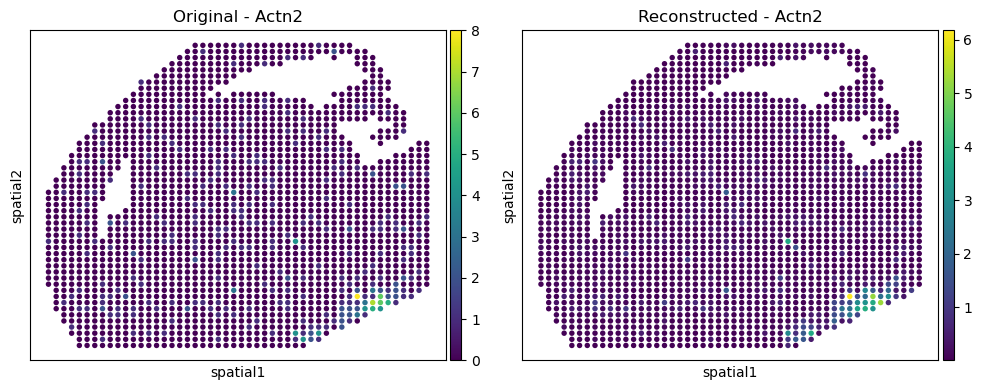


--- Quantitative Analysis ('Actn2') ---
Pearson Correlation (Original vs Reconstructed): 0.8724 (P-value: 0.0000e+00)




 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


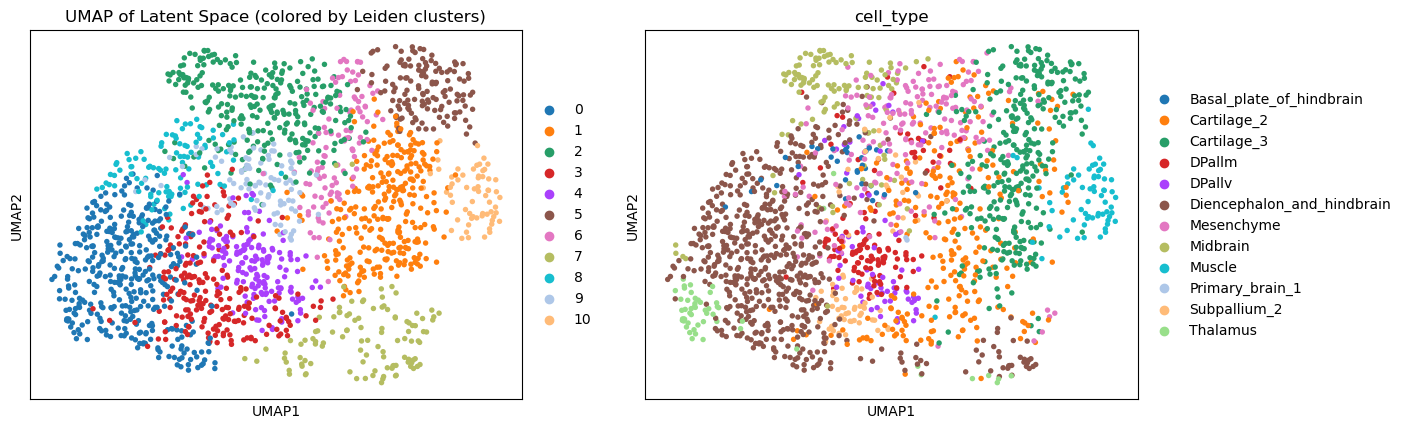

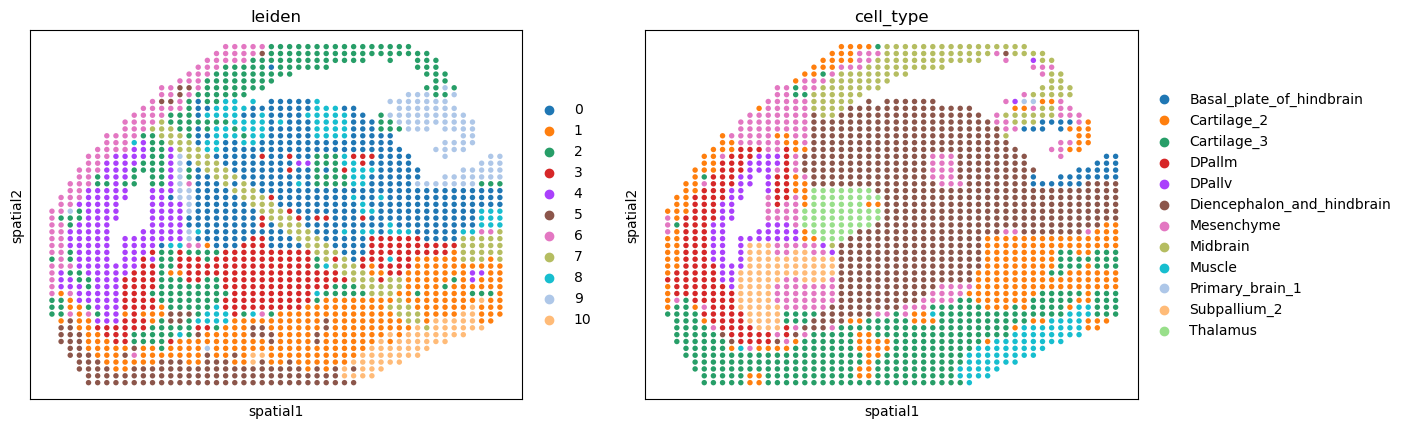


Starting Comprehensive Evaluation for S1 data

--- 1. Starting Reconstruction Fidelity Evaluation (S1) ---
  [Matrix-level] Pearson Correlation: 0.9573


  [Peak-level] Mean Pearson Correlation: 0.8486


  [Cell-level] Mean Pearson Correlation: 0.9812
  Detailed evaluation results saved to: ./output_refactored/S1_evaluation_results

--- 2. Starting Biological Consistency Evaluation ---
  Adjusted Rand Index (ARI): 0.2630 (closer to 1 is better)
  Normalized Mutual Information (NMI): 0.4121 (closer to 1 is better)

--- 3. Starting Spatial Structure Coherence Evaluation ---
  Spatial evaluation failed: Reindexing only valid with uniquely valued Index objects

Evaluation for S1 data complete


In [8]:
import SpaDiffusion.evaluation_metrics as evm

sc.pp.calculate_qc_metrics(S1_RNA_data, percent_top=None, log1p=False, inplace=True)

marker_peak = 'Actn2'
validate_reconstruction(S1_RNA_data, reconstructed_data, gene_to_plot=marker_peak)
    
S1_RNA_data.obs['Harmony_ATAC_0.35'] = S1_RNA_data.obs['Harmony_ATAC_0.35'].astype('category')
S1_RNA_data.obs['Harmony_RNA_0.7'] = S1_RNA_data.obs['Harmony_RNA_0.7'].astype('category')

sc.pp.neighbors(S1_RNA_data, use_rep='X_vae')
sc.tl.umap(S1_RNA_data)
sc.tl.leiden(S1_RNA_data,resolution=0.8)
    
sc.pl.umap(S1_RNA_data, color=['leiden','cell_type'], title='UMAP of Latent Space (colored by Leiden clusters)')
sc.pl.embedding(S1_RNA_data,basis='spatial', color=['leiden','cell_type'])

reconstructed_data_s1 = trainer.get_reconstruction()

evm.run_comprehensive_evaluation(
    adata=S1_RNA_data,
    recon_matrix=reconstructed_data_s1,
    prefix='S1',
    ground_truth_key='Harmony_ATAC_0.35', 
    cluster_key='leiden',         
    output_dir=os.path.join(OUTPUT_DIR, 'S1_evaluation_results')
)

In [9]:
evm.run_comprehensive_evaluation(
    adata=S1_RNA_data,
    recon_matrix=reconstructed_data_s1,
    prefix='S1',
    ground_truth_key='cell_type', 
    cluster_key='leiden',         
    output_dir=os.path.join(OUTPUT_DIR, 'S1_evaluation_results')
)


Starting Comprehensive Evaluation for S1 data

--- 1. Starting Reconstruction Fidelity Evaluation (S1) ---
  [Matrix-level] Pearson Correlation: 0.9573


  [Peak-level] Mean Pearson Correlation: 0.8486


  [Cell-level] Mean Pearson Correlation: 0.9812
  Detailed evaluation results saved to: ./output_refactored/S1_evaluation_results

--- 2. Starting Biological Consistency Evaluation ---
  Adjusted Rand Index (ARI): 0.3339 (closer to 1 is better)
  Normalized Mutual Information (NMI): 0.4782 (closer to 1 is better)

--- 3. Starting Spatial Structure Coherence Evaluation ---
  Spatial evaluation failed: Reindexing only valid with uniquely valued Index objects

Evaluation for S1 data complete


In [10]:

recon_s1 = ad.AnnData(reconstructed_data_s1,obs=S1_RNA_data.obs.copy(),var=S1_RNA_data.var.copy(),obsm=S1_RNA_data.obsm.copy())
recon_s1.write_h5ad('S1_RNA_reconstructed_pretrain2_res.h5ad')

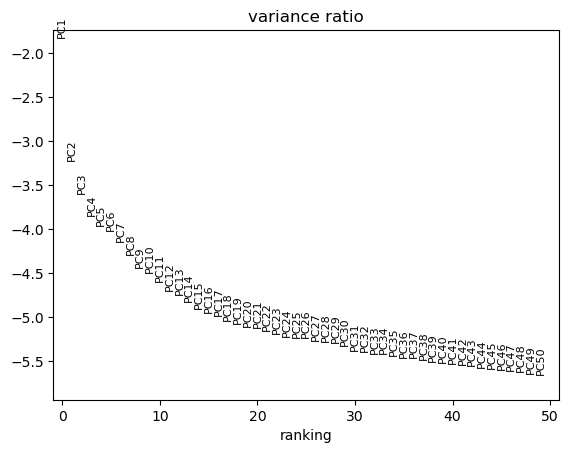

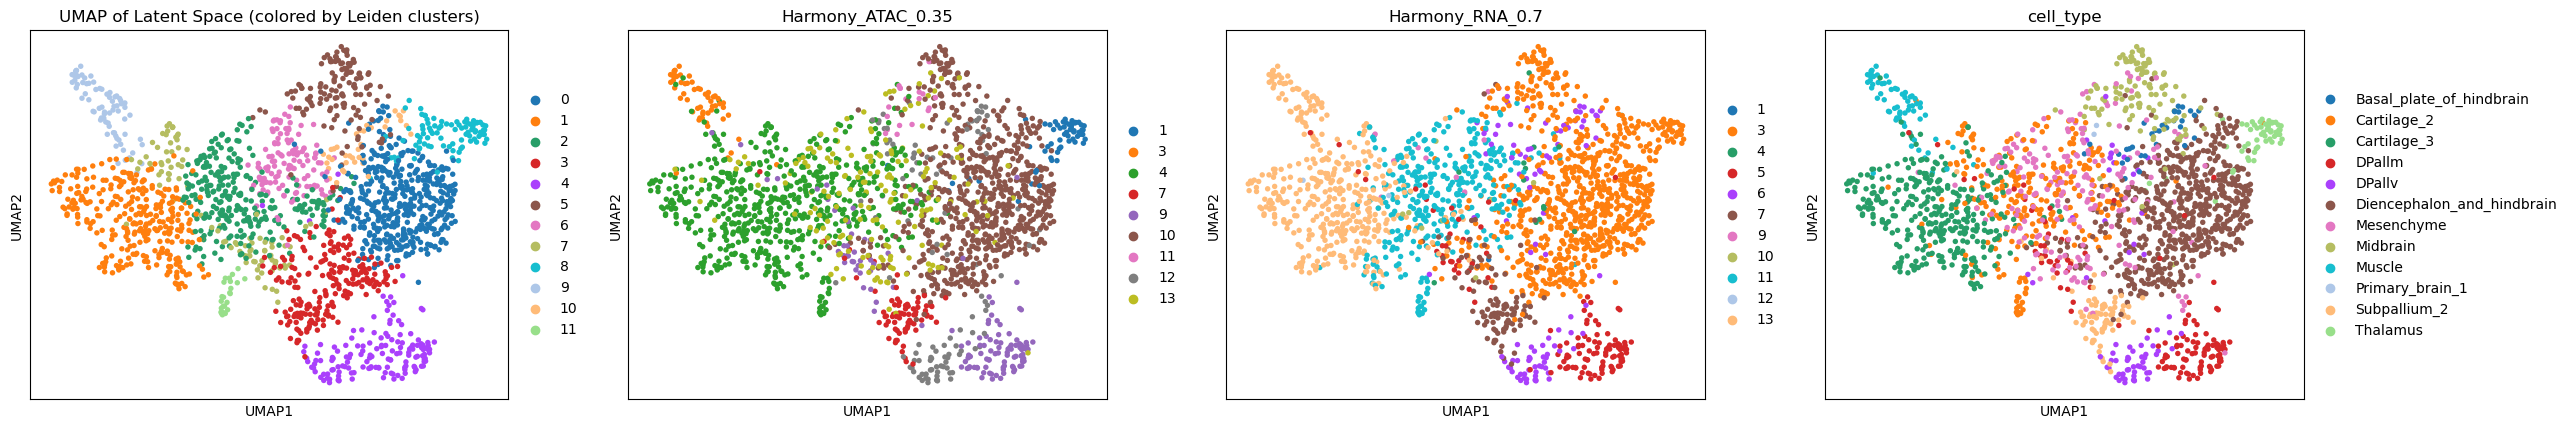

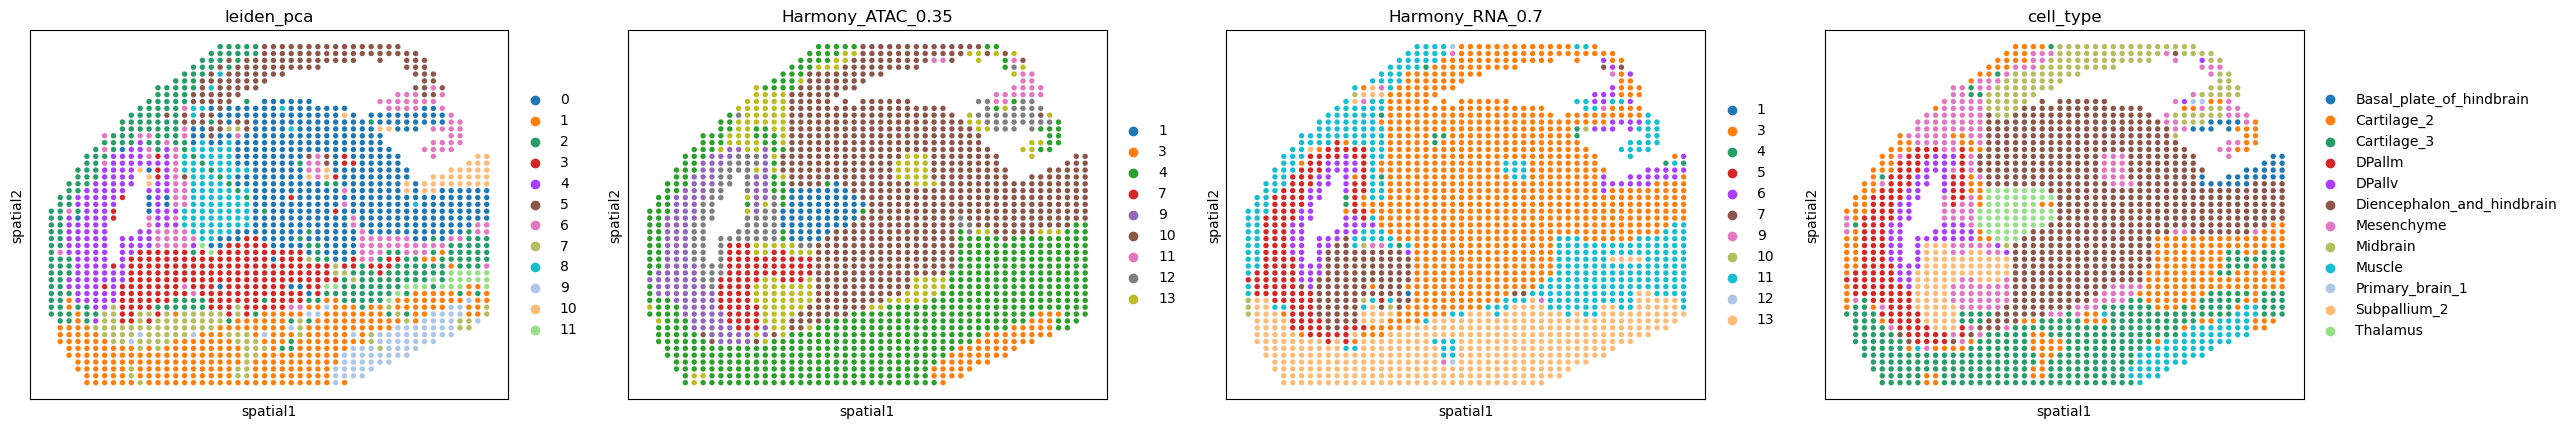

In [11]:
import SpaDiffusion.evaluation_metrics as evm
sc.pp.normalize_total(recon_s1)
# Logarithmize the data
sc.pp.log1p(recon_s1)

sc.tl.pca(recon_s1,n_comps=50)
sc.pl.pca_variance_ratio(recon_s1, n_pcs=50, log=True)
sc.pp.neighbors(recon_s1,use_rep='X_pca',n_pcs=50)
sc.tl.umap(recon_s1)
sc.tl.leiden(recon_s1, n_iterations=2,key_added='leiden_pca',resolution=0.8)
    
sc.pl.umap(recon_s1, color=['leiden_pca','Harmony_ATAC_0.35','Harmony_RNA_0.7','cell_type'], title='UMAP of Latent Space (colored by Leiden clusters)')
sc.pl.embedding(recon_s1,basis='spatial', color=['leiden_pca','Harmony_ATAC_0.35','Harmony_RNA_0.7','cell_type'])


In [12]:
# --- 2. Evaluation on S2 data (new data) ---
print("\n--- Evaluating S2 Dataset ---")

# Prepare S2 tensors
s2_tensor = trainer._get_tensor_from_adata(S2_RNA_data)
s2_edge_index = trainer._get_edge_index_from_adata(S2_RNA_data)

# Generate latent representation for S2
s2_latent_representation = model.get_latent_representation(s2_tensor, s2_edge_index)

# 4. Store the latent representation back into S2_RNA_data.obsm
S2_RNA_data.obsm['X_vae'] = s2_latent_representation

print("\n--- S2 Latent Space Generation Complete ---")
print(f"Latent embeddings successfully added to S2_RNA_data.obsm['X_vae']")
print(f"Embedding Shape: {S2_RNA_data.obsm['X_vae'].shape}")
    
# Get reconstruction for S2
with torch.no_grad():
    output_s2 = model(s2_tensor, s2_edge_index, deterministic=True)
    if model.reconstruction_loss == 'bce':
        recon_probs_s2 = torch.sigmoid(output_s2['recon_logits'])
        reconstructed_data_s2 = recon_probs_s2.cpu().numpy()
    elif model.reconstruction_loss == 'nb':
        # Use the mean (mu) of the Negative Binomial distribution for reconstruction
        reconstructed_data_s2 = output_s2['recon_mu'].cpu().numpy()

# Convert original matrix to array if sparse for comparison
orig_matrix_s2 = S2_RNA_data.X.toarray() if isinstance(S2_RNA_data.X, sparse.spmatrix) else S2_RNA_data.X

print("\n" + "="*50)
print("--- COMPREHENSIVE EVALUATION COMPLETE ---")
print("="*50)


--- Evaluating S2 Dataset ---

--- S2 Latent Space Generation Complete ---
Latent embeddings successfully added to S2_RNA_data.obsm['X_vae']
Embedding Shape: (1939, 256)

--- COMPREHENSIVE EVALUATION COMPLETE ---


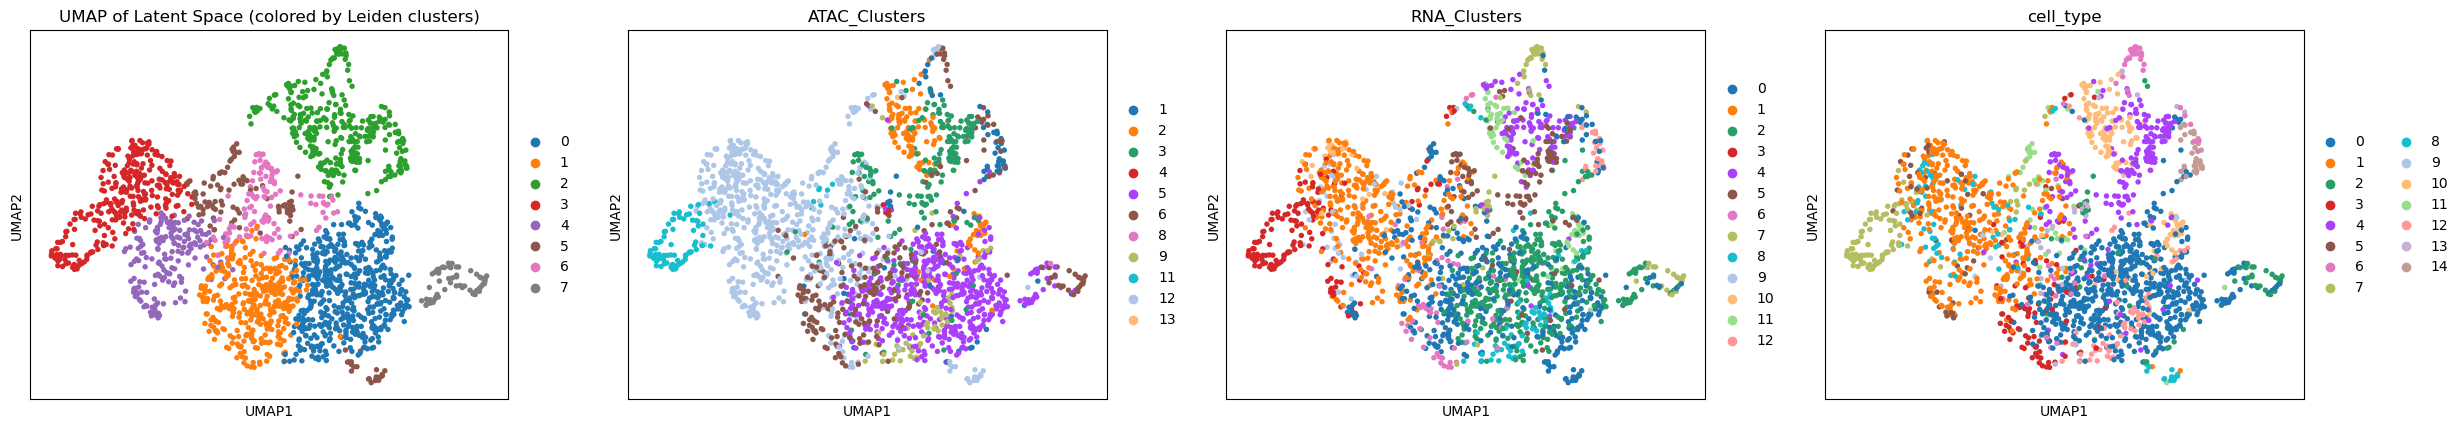

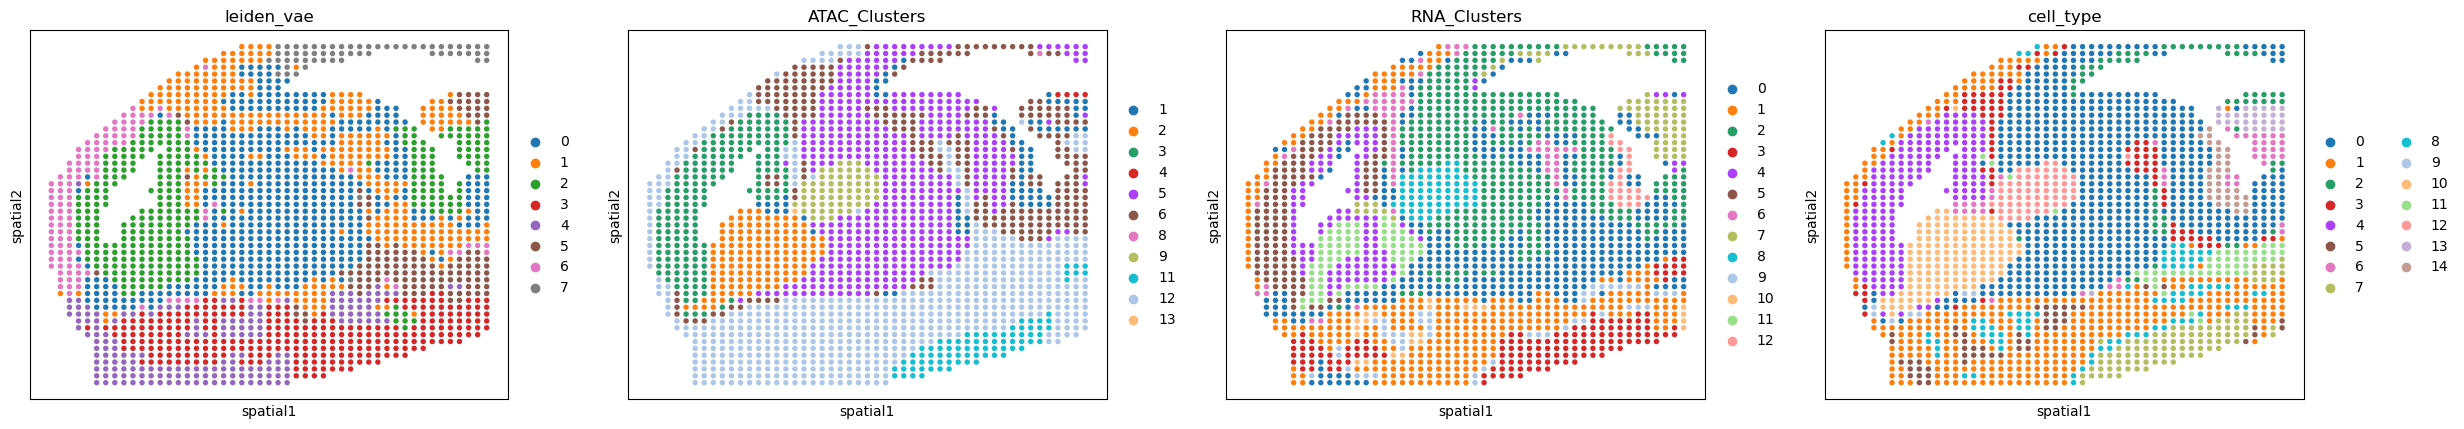


Starting Comprehensive Evaluation for S2 data

--- 1. Starting Reconstruction Fidelity Evaluation (S2) ---
  [Matrix-level] Pearson Correlation: 0.7596


  [Peak-level] Mean Pearson Correlation: 0.0986


  [Cell-level] Mean Pearson Correlation: 0.9381
  Detailed evaluation results saved to: ./output_refactored/S2_evaluation_results

--- 2. Starting Biological Consistency Evaluation ---
  Adjusted Rand Index (ARI): 0.2294 (closer to 1 is better)
  Normalized Mutual Information (NMI): 0.3823 (closer to 1 is better)

--- 3. Starting Spatial Structure Coherence Evaluation ---
  Spatial evaluation failed: Reindexing only valid with uniquely valued Index objects

Evaluation for S2 data complete


In [13]:
    
sc.pp.calculate_qc_metrics(S2_RNA_data, percent_top=None, log1p=False, inplace=True)

S2_RNA_data.obs['ATAC_Clusters'] = S2_RNA_data.obs['ATAC_Clusters'].astype('category')
S2_RNA_data.obs['RNA_Clusters'] = S2_RNA_data.obs['RNA_Clusters'].astype('category')

sc.pp.neighbors(S2_RNA_data, use_rep='X_vae')
sc.tl.umap(S2_RNA_data)
sc.tl.leiden(S2_RNA_data,resolution=0.5,key_added='leiden_vae')
    
sc.pl.umap(S2_RNA_data, color=['leiden_vae','ATAC_Clusters','RNA_Clusters','cell_type'], title='UMAP of Latent Space (colored by Leiden clusters)')
sc.pl.embedding(S2_RNA_data,basis='spatial', color=['leiden_vae','ATAC_Clusters','RNA_Clusters','cell_type'])
evm.run_comprehensive_evaluation(
    adata=S2_RNA_data,
    recon_matrix=reconstructed_data_s2,
    prefix='S2',
    ground_truth_key='RNA_Clusters', 
    cluster_key='leiden_vae',         
    output_dir=os.path.join(OUTPUT_DIR, 'S2_evaluation_results')
)

In [14]:
recon_s2= ad.AnnData(reconstructed_data_s2,obs=S2_RNA_data.obs.copy(), var=S2_RNA_data.var.copy(),obsm=S2_RNA_data.obsm.copy())
recon_s2.write_h5ad('S2_RNA_reconstructed_pretrain2_res.h5ad')

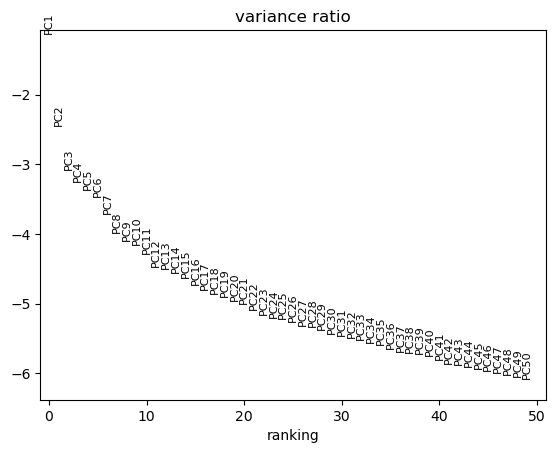

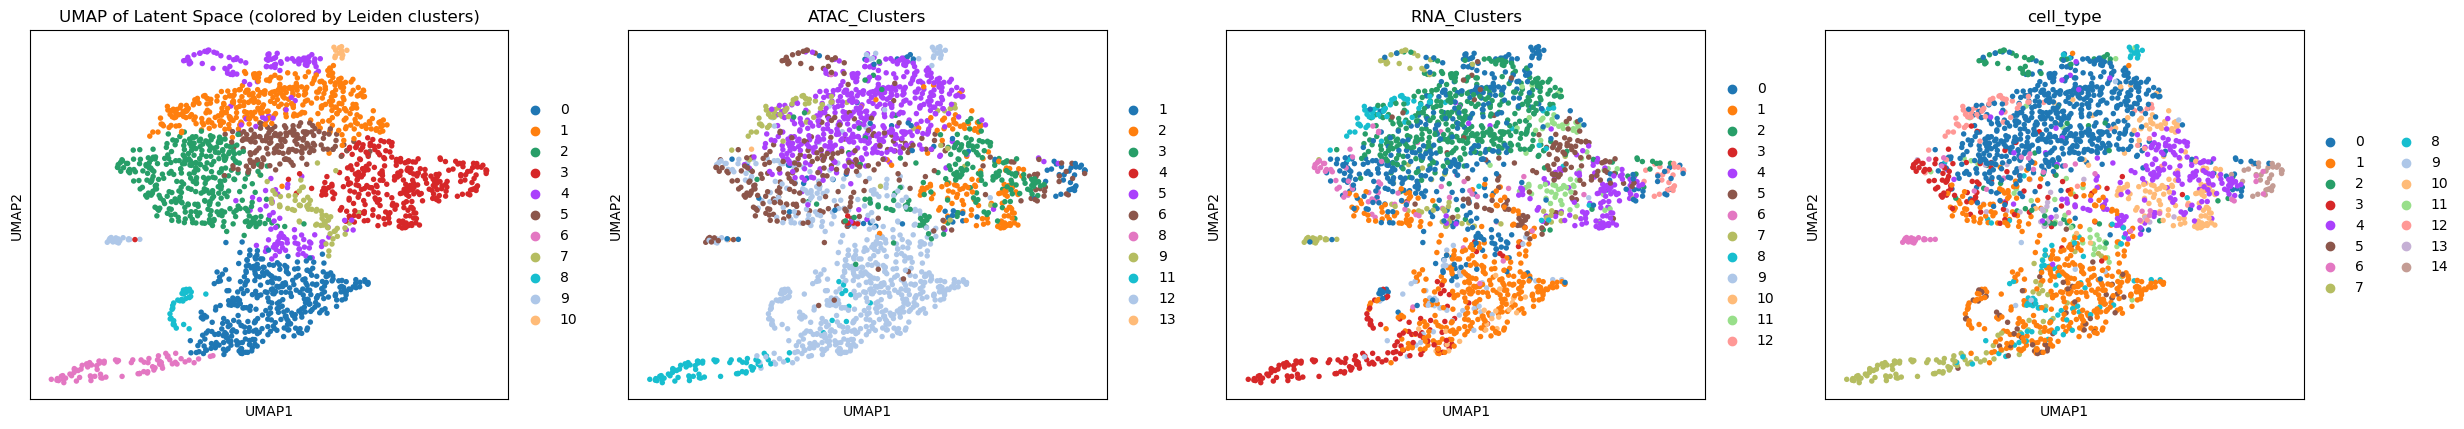

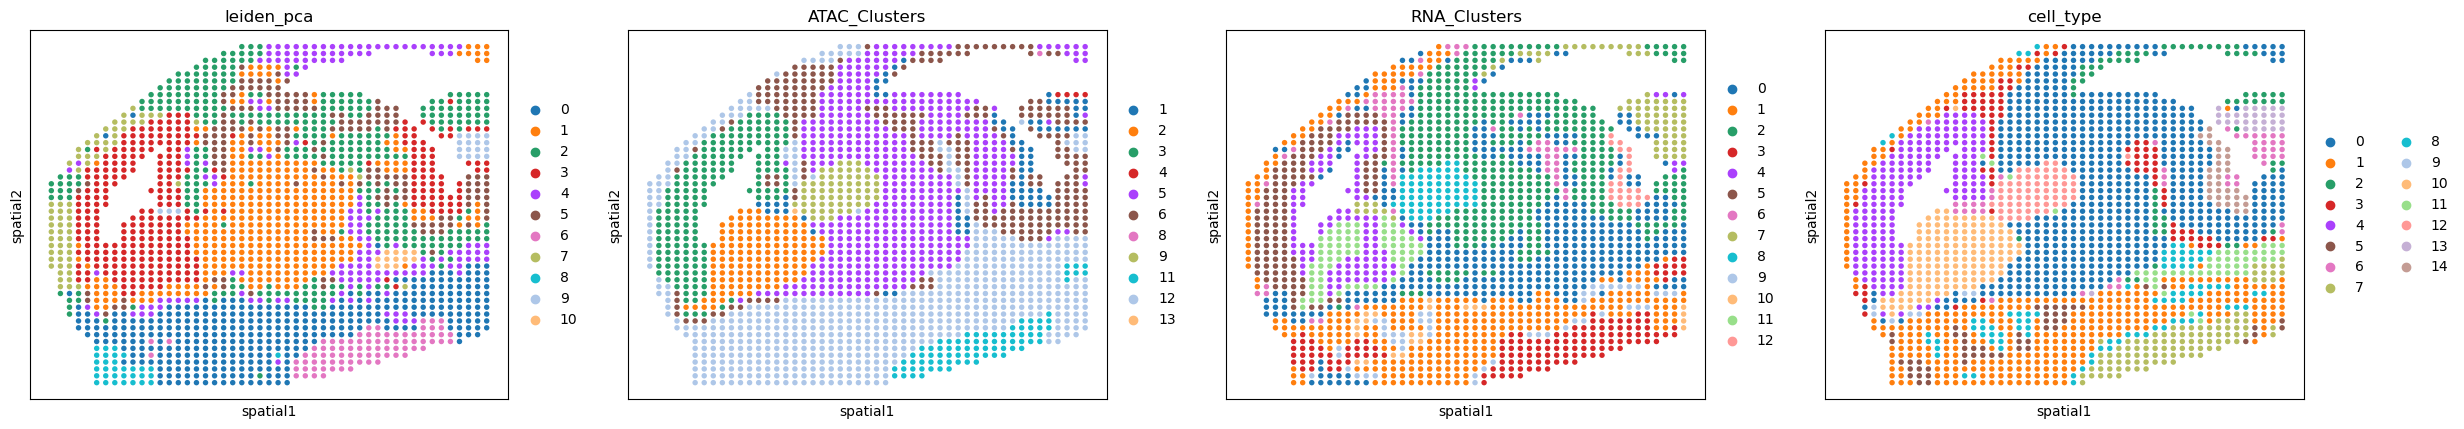

In [15]:
import SpaDiffusion.evaluation_metrics as evm
sc.pp.normalize_total(recon_s2)

sc.pp.log1p(recon_s2)

sc.tl.pca(recon_s2)
sc.pl.pca_variance_ratio(recon_s2, n_pcs=50, log=True)
sc.pp.neighbors(recon_s2)
sc.tl.umap(recon_s2)
sc.tl.leiden(recon_s2, n_iterations=2,key_added='leiden_pca',resolution=0.5)
    
sc.pl.umap(recon_s2, color=['leiden_pca','ATAC_Clusters','RNA_Clusters','cell_type'], title='UMAP of Latent Space (colored by Leiden clusters)')
sc.pl.embedding(recon_s2,basis='spatial', color=['leiden_pca','ATAC_Clusters','RNA_Clusters','cell_type'])
